
## IRIS Dataset analysis using K-Means 



In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.appName('IRIS-Clustering').getOrCreate()

24/01/28 17:04:25 WARN Utils: Your hostname, Sais-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.150.141.237 instead (on interface en0)
24/01/28 17:04:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/28 17:04:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'IRIS-Clustering'),
 ('spark.app.startTime', '1706483065393'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.driver.port', '59230'),
 ('s

### Load data

In [8]:
#get IRIS data from URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("iris.data"), header=False, inferSchema= True)
df = spark.createDataFrame(df.rdd, ["PetalWidth","PetalLength","SepalWidth","SepalLength","Label"])
df.show(10)

+----------+-----------+----------+-----------+-----------+
|PetalWidth|PetalLength|SepalWidth|SepalLength|      Label|
+----------+-----------+----------+-----------+-----------+
|       5.1|        3.5|       1.4|        0.2|Iris-setosa|
|       4.9|        3.0|       1.4|        0.2|Iris-setosa|
|       4.7|        3.2|       1.3|        0.2|Iris-setosa|
|       4.6|        3.1|       1.5|        0.2|Iris-setosa|
|       5.0|        3.6|       1.4|        0.2|Iris-setosa|
|       5.4|        3.9|       1.7|        0.4|Iris-setosa|
|       4.6|        3.4|       1.4|        0.3|Iris-setosa|
|       5.0|        3.4|       1.5|        0.2|Iris-setosa|
|       4.4|        2.9|       1.4|        0.2|Iris-setosa|
|       4.9|        3.1|       1.5|        0.1|Iris-setosa|
+----------+-----------+----------+-----------+-----------+
only showing top 10 rows



In [9]:
#Vectorizing the Petal and Sepal features

from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=[
'PetalWidth',
'PetalLength',
'SepalWidth',
'SepalLength'],outputCol = 'iris_features')

transformed_df =assemble.transform(df)

In [10]:
transformed_df.show(5)

+----------+-----------+----------+-----------+-----------+-----------------+
|PetalWidth|PetalLength|SepalWidth|SepalLength|      Label|    iris_features|
+----------+-----------+----------+-----------+-----------+-----------------+
|       5.1|        3.5|       1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|       4.9|        3.0|       1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|       4.7|        3.2|       1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
|       4.6|        3.1|       1.5|        0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|
|       5.0|        3.6|       1.4|        0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|
+----------+-----------+----------+-----------+-----------+-----------------+
only showing top 5 rows



iris_features columns looks accurate

In [11]:
# Running K-means for 2-10 k values

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='iris_features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='iris_features', k=K)

    KMeans_fit=KMeans_.fit(transformed_df)

    KMeans_transform=KMeans_fit.transform(transformed_df) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

24/01/28 17:08:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=37351Kb max_used=37351Kb free=93720Kb
 bounds [0x00000001089e0000, 0x000000010ae90000, 0x00000001109e0000]
 total_blobs=14019 nmethods=12844 adapters=1086
 compilation: disabled (not enough contiguous free space left)


Text(0, 0.5, 'Silhouette Score')

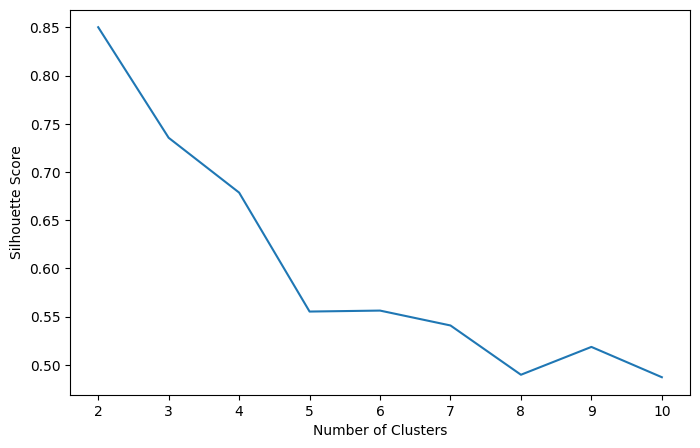

In [12]:
fig, ax = plt.subplots(1,1, figsize =(8,5))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

### K-Means prediction 

In [13]:
# Training the model
kmeans = KMeans(featuresCol='iris_features', k=3) 
model = kmeans.fit(transformed_df)


In [14]:
# Making predictions
predictions = model.transform(transformed_df)

### Model Evaluation

In [16]:
# Evaluating the clustering model by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol='iris_features')

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.7354567373091194
Cluster Centers: 
[5.9016129  2.7483871  4.39354839 1.43387097]
[5.006 3.418 1.464 0.244]
[6.85       3.07368421 5.74210526 2.07105263]


Silhouette Score: 0.7355

The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). A silhouette score ranges from -1 to 1, where a higher value indicates better-defined clusters. In this case, a silhouette score of 0.7355 suggests that the clusters are well-separated and have a high degree of cohesion.

Cluster Centers:

The cluster centers represent the mean feature values for each cluster. For each cluster, you have a set of values corresponding to the four features of the Iris dataset (sepal length, sepal width, petal length, and petal width).

Cluster 1: [5.9016129, 2.7483871, 4.39354839, 1.43387097]

Cluster 2: [5.006, 3.418, 1.464, 0.244]

Cluster 3: [6.85, 3.07368421, 5.74210526, 2.07105263]

These cluster centers provide a summary of the characteristic feature values for each cluster. They serve as the representative points around which the data points in each cluster are grouped.

In summary, K-means algorithm has partitioned the Iris dataset into three clusters, with well-defined and cohesive clusters as indicated by the high silhouette score. The cluster centers represent the mean feature values for each cluster, offering insights into the characteristics of the data within each group. This information can be used to  understanding patterns and potential groupings within the Iris dataset based on the features provided.